# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [20]:
!pip install torch==2.3.0+cu121 torchvision==0.18.0 --index-url https://download.pytorch.org/whl/cu121
!pip install ultralytics==8.2.77
!pip install matplotlib==3.9.2
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install sympy==1.12
!pip install requests==2.32.3
!pip install ipykernel==6.29.5
!pip install pyarrow==15.0.2

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 9.6 MB/s eta 0:04:12
     ---------------------------------------- 0.0/2.4 GB 11.0 MB/s eta 0:03:39
     ---------------------------------------- 0.0/2.4 GB 11.4 MB/s eta 0:03:32
     ---------------------------------------- 0.0/2.4 GB 11.9 MB/s eta 0:03:24
     ---------------------------------------- 0.0/2.4 GB 11.5 MB/s eta 0:03:30
     ---------------------------------------- 0.0/2.4 GB 11.4 MB/s eta 0:03:32
     ---------------------------------------- 0.0/2.4 GB 11.5 MB/s eta 0:03:30
     ---------------------------------------- 0.0/2.4 GB 11.6 MB/s eta 0:03:29
     ---------------------------------------- 0.0/2.4 GB 11.7 MB/s eta 0:03:27
     ---------------------------------------- 0.0/2.4 GB 11.6 MB/s eta 0:03:27
     ---------------------------------------- 0.0/2.4 GB 11.7 MB/s eta 0:03:27
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1+cu121, but you have torch 2.3.0+cu121 which is incompatible.


     ----------------------- ---------------- 1.4/2.4 GB 9.8 MB/s eta 0:01:41
     ----------------------- ---------------- 1.4/2.4 GB 9.8 MB/s eta 0:01:40
     ----------------------- ---------------- 1.4/2.4 GB 9.5 MB/s eta 0:01:43
     ----------------------- ---------------- 1.4/2.4 GB 9.8 MB/s eta 0:01:40
     ----------------------- ---------------- 1.4/2.4 GB 9.8 MB/s eta 0:01:40
     ----------------------- ---------------- 1.4/2.4 GB 9.8 MB/s eta 0:01:40
     ----------------------- ---------------- 1.4/2.4 GB 10.4 MB/s eta 0:01:34
     ----------------------- ---------------- 1.4/2.4 GB 10.7 MB/s eta 0:01:31
     ----------------------- ---------------- 1.4/2.4 GB 10.6 MB/s eta 0:01:33
     ----------------------- ---------------- 1.4/2.4 GB 10.2 MB/s eta 0:01:36
     ----------------------- ---------------- 1.4/2.4 GB 10.2 MB/s eta 0:01:36
     ----------------------- ---------------- 1.4/2.4 GB 10.2 MB/s eta 0:01:36
     ----------------------- ---------------- 1.4/2.4 GB 1

ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'C:\\Users\\Administrator\\anaconda3\\Lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB 435.7 kB/s eta 0:00:18
    --------------------------------------- 0.1/7.8 MB 1.4 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/7.8 MB 3.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/7.8 MB 5.5 MB/s eta 0:00:02
   -------- ------------------------------- 1.6/7.8 MB 7.0 MB/s eta 0:00:01
   ----------- ---------------------------- 2.2/7.8 MB 7.7 MB/s eta 0:00:01
   ------------- -------------------------- 2.7/7.8 MB 8.2 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/7.8 MB 8.6 MB/s eta 0:00:01
   ------------------ --------------------- 3.5/7.8 MB 8.3 MB/s eta 0:00:01
   --------------------- ------------------ 4.2/7.8 MB 9.3 MB/s eta 0:00:01
   ---------------------- ----------------- 4.3/7.8 MB 8.4 MB/s eta 0:00:01
   ---------------------

ERROR: Cannot uninstall matplotlib 3.10.7, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps matplotlib==3.10.7'.


   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB 640.0 kB/s eta 0:00:19
    --------------------------------------- 0.3/11.6 MB 3.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/11.6 MB 5.0 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/11.6 MB 6.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/11.6 MB 7.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.2/11.6 MB 8.4 MB/s eta 0:00:02
   --------- ------------------------------ 2.8/11.6 MB 8.9 MB/s eta 0:00:01
   ----------- ---------------------------- 3.4/11.6 MB 9.3 MB/s eta 0:00:01
   ------------- -------------------------- 3.9/11.6 MB 9.6 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.6 MB 9.9 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.6 MB 10.0 MB/s eta 0:00:01
   ------------------- -------------------- 5.6/11.6 MB 10.2 MB/s eta 0:00:01
  

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.30.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.


   ---------------------------------------- 0.0/64.9 kB ? eta -:--:--
   ------ --------------------------------- 10.2/64.9 kB ? eta -:--:--
   ------------------ --------------------- 30.7/64.9 kB 435.7 kB/s eta 0:00:01
   ---------------------------------------- 64.9/64.9 kB 701.1 kB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires python-dateutil==2.8.2, but you have python-dateutil 2.9.0.post0 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.30.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.


   ---------------------------------------- 0.0/117.2 kB ? eta -:--:--
   --- ------------------------------------ 10.2/117.2 kB ? eta -:--:--
   ---------- ---------------------------- 30.7/117.2 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 117.2/117.2 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.28.0
    Uninstalling ipykernel-6.28.0:
      Successfully uninstalled ipykernel-6.28.0
   ---------------------------------------- 0.0/24.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.8 MB 640.0 kB/s eta 0:00:39
   ---------------------------------------- 0.2/24.8 MB 1.5 MB/s eta 0:00:17
    --------------------------------------- 0.5/24.8 MB 3.7 MB/s eta 0:00:07
   - -------------------------------------- 1.1/24.8 MB 5.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.7/24.8 MB 7.0 MB/s eta 0:00:04
   

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.30.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.


In [1]:
import sys
print(sys.executable)

C:\Users\Administrator\anaconda3\python.exe


In [2]:

%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd
import torch
import sympy

## Data Collection

Download the training and test datasets.

In [3]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')

# Download the files
download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')

Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl


In [4]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [5]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

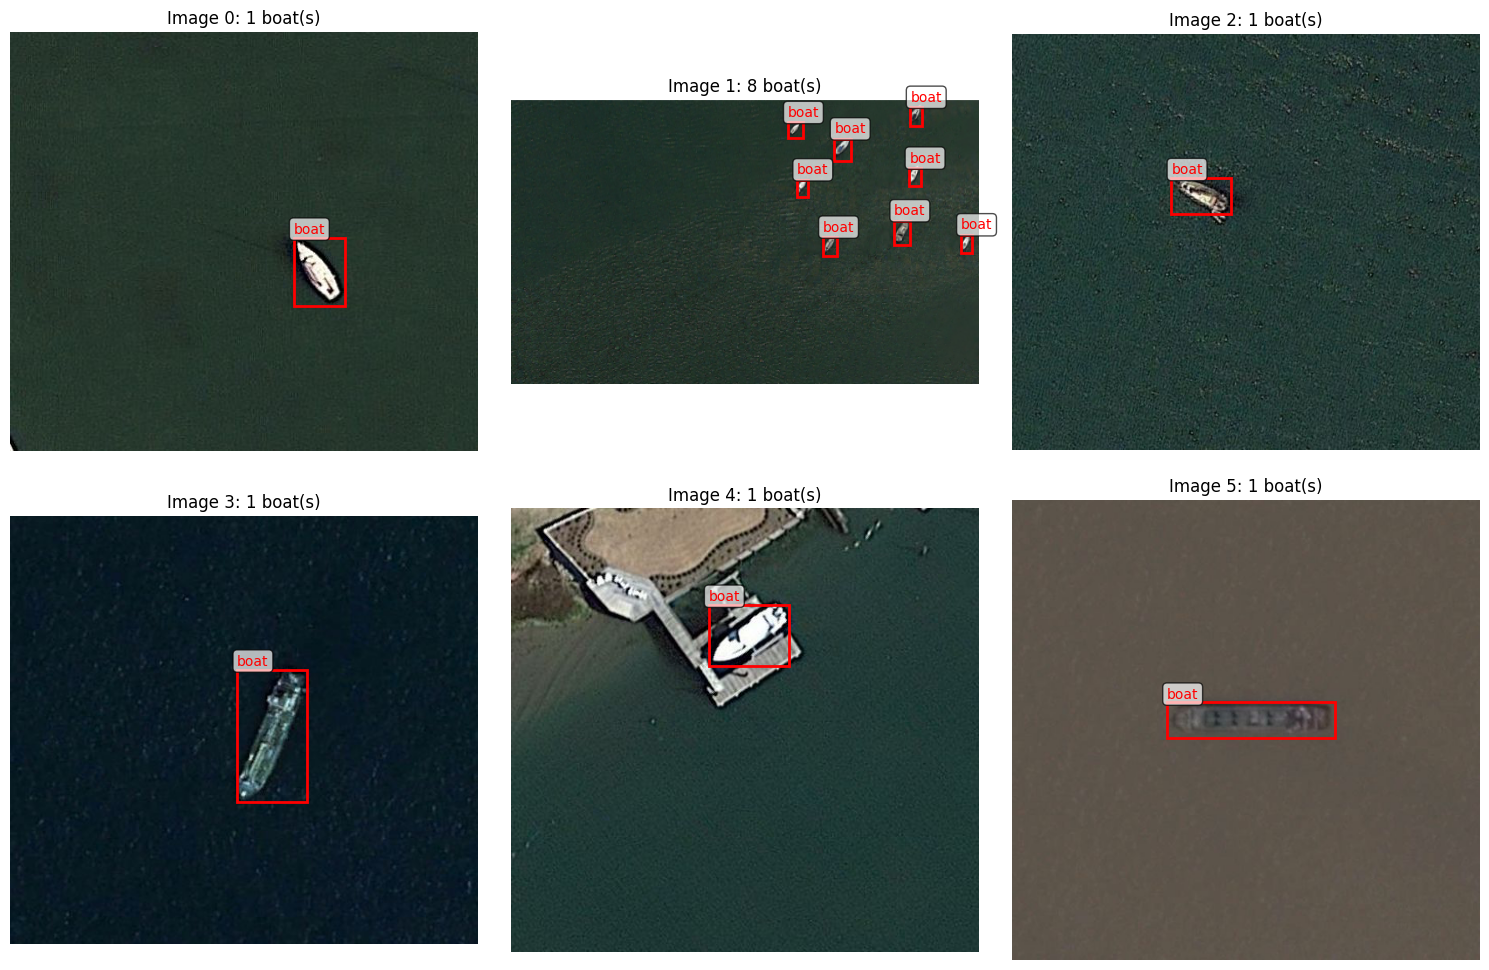

In [6]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [7]:

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Model loaded successfully!


In [8]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 C:\Users\Administrator\M2\SD\Module 7\temp_sample.png: 576x640 1 tennis racket, 39.3ms
Speed: 3.6ms preprocess, 39.3ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [9]:
import os
from PIL import Image
import numpy as np

# 1. 创建 YOLO 格式数据集目录
os.makedirs("boat_dataset/images/train", exist_ok=True)
os.makedirs("boat_dataset/labels/train", exist_ok=True)

# 2. 转换为 YOLO 所需格式
for idx, (img_array, boxes) in enumerate(zip(X, y)):
    # 转换为 PIL 图像
    img = Image.fromarray(img_array.astype(np.uint8))
    if img.mode == 'RGBA':  # 👈 修正：确保转换为 RGB
        img = img.convert('RGB')
    img.save(f"boat_dataset/images/train/{idx}.jpg")
    
    # 保存对应的 YOLO 标签
    label_path = f"boat_dataset/labels/train/{idx}.txt"
    with open(label_path, "w") as f:
        for box in boxes:
            class_id, x_center, y_center, width, height = box
            f.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")

# 3. 创建 YOLO 数据配置文件
yaml_text = """path: boat_dataset
train: images/train
val: images/train
nc: 1
names: ['boat']
"""
with open("boat_dataset.yaml", "w") as f:
    f.write(yaml_text)


# 4. 微调 YOLO 模型
device = 0 if torch.cuda.is_available() else 'cpu'
results = model.train(
    data="boat_dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    lr0=0.001,
    device=device,
    workers=0 
)

print("✅")

# 5. 验证模型性能 (mAP@0.5)
metrics = model.val()
print(f" Final mAP@0.5: {metrics.box.map50:.3f}")


New https://pypi.org/project/ultralytics/8.3.214 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.213  Python-3.11.7 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce MX450, 2048MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train12, nbs=64, nms=False, opset=None, op

## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [10]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [11]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model.predict(source='temp_test.png', conf=0.25, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 68


In [12]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         8        0         0    0.441249  0.592931  0.475514  0.169874   
1         9        0         0    0.326025  0.554065  0.525330  0.205861   
2        13        0         0    0.273208  0.271222  0.482766  0.270190   
3        15        0         0    0.492731  0.484478  0.414104  0.126098   
4        16        0         0    0.425015  0.454327  0.388593  0.241952   
5        16        1         0    0.298279  0.454746  0.389681  0.242045   
6        18        0         0    0.261672  0.223757  0.348427  0.131816   
7        19        0         0    0.390122  0.440069  0.414793  0.213702   
8        21        0         0    0.681832  0.551698  0.612663  0.187439   
9        26        0         0    0.494985  0.509390  0.487086  0.076486   

     height  
0  0.076654  
1  0.280519  
2  0.209556  
3  0.383791  
4  0.279050  
5  0.280721  
6  0